In [2]:
import os
import sys
import casadi as cd
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(os.path.abspath(os.getcwd()))
from Envs.pendulum import Pendulum_Env,Pendulum_Model
from Solvers.OCsolver import ocsolver_v2
from Solvers.Cutter import cutter_v2
from Solvers.MVEsolver import mvesolver
from utils.Correction import Correction_Agent
import numpy as np
from matplotlib import pyplot as plt
import time

In [3]:
def pendulum_eval():
    # get dynamics, set up step cost and terminal cost
    #0.05
    p_model=Pendulum_Model(10,1,1,0.4,0.02)

    P_matrix=np.array([[0.0,0],
                   [0,0.0]])
    T_matrix=np.array([[25,0],
                   [0,10]])



    dyn_func=p_model.get_dyn_f()
    step_func=p_model.get_step_cost(P_matrix,0.1)
    terminal_func=p_model.get_terminal_cost(T_matrix)

    # set up safety features
    Horizon=40
    Gamma=0.1
    def generate_phi():
            traj=cd.SX.sym('xi',3*Horizon + 2)
            phi=cd.vertcat(cd.DM(-3),traj[3:5])
            return cd.Function('phi',[traj],[phi])

    phi_func=generate_phi() #traj: [x,u,x,u,..,x] phi:[phi0, phi1, phi2]

    lbs=np.array([-6,-6]) #-6
    ubs=np.array([2,2])

    weights_init=(lbs+ubs)/2
    weights_H=np.array([0.6,1])

    #construct environment
    p_env=Pendulum_Env(10,1,1,0.4,0.02)
    p_env.set_init_state(np.array([0,0]))
    #p_env.set_noise(False)
    #construct correction agent
    agent=Correction_Agent('dummy')
    agent.set_state_dim(2)
    agent.set_ctrl_dim(1)
    agent.set_dyn(dyn_func)
    agent.set_step_cost(step_func)
    agent.set_term_cost(terminal_func)
    agent.set_g(phi_func,weights=weights_H,gamma=Gamma)
    #agent.set_threshold(-0.1) #-0.5
    agent.set_threshold(-0.25) #-0.5
    agent.set_p(0.3)
    agent.construct_graph(horizon=Horizon)

    #construct controller
    controller=ocsolver_v2('pendulum control')
    controller.set_state_param(2,[-2*np.pi,-100],[2*np.pi,100])
    controller.set_ctrl_param(1,[-1e10],[1e10])
    controller.set_dyn(dyn_func)
    controller.set_step_cost(step_func)
    controller.set_term_cost(terminal_func)
    #controller.construct_graph(horizon=Horizon)
    controller.set_g(phi_func,gamma=Gamma)
    controller.construct_prob(horizon=Horizon)

    #construct cutter
    hb_calculator=cutter_v2('pendulum cut')
    hb_calculator.from_controller(controller)
    hb_calculator.construct_graph(horizon=Horizon)

    #construct MVESolver
    mve_calc=mvesolver('pendulum_mve',2)

    mve_calc.set_init_constraint(lbs, ubs) #Theta_0

    learned_theta=np.array(weights_init)

    #learning logs
    theta_log=[np.array(weights_init)]
    error_log=[np.linalg.norm(weights_init-weights_H)]

    d_0,C_0=mve_calc.solve()
    v_0=np.log(np.linalg.det(C_0))
    volume_log=[v_0]

    EPISODE=0
    corr_num=0
    termination_flag=False
    while not termination_flag:
        #print('episode',EPISODE)
        # random init
        init_state=np.array([0.,0.])
        init_state[0] += np.random.uniform(0,2*np.pi/3)
        init_state[1] += np.random.uniform(0,3)
        p_env.set_init_state(init_state)
        for i in range(200):
            x=p_env.get_curr_state()
            if np.sqrt(np.sum((x-np.array([np.pi,0]))**2)) <=0.15:
                print('reached desired position')
                break
            #print(i)
            u=controller.control(x,weights=learned_theta)
            agent_output=agent.act(controller.opt_traj)
            if agent_output is None:
                #print('emergency stop')
                break
            elif type(agent_output)==bool:
                pass
            else:
                st=time.time()
                h,b,h_phi,b_phi=hb_calculator.calc_planes(learned_theta,x,controller.opt_traj,np.sign(agent_output))
                #print('cutting plane calculated')
                #print('h',h)
                #print('b',b)
                #print('diff', h.T @ learned_theta - b)
                #print('h_phi',h_phi)
                #print('b_phi',b_phi)

                mve_calc.add_constraint(h,b[0])
                mve_calc.add_constraint(h_phi,b_phi[0])
                learned_theta,C=mve_calc.solve()
                print('learning time', time.time()-st)
                #difference=np.linalg.norm(learned_theta-weights_H)
                difference=learned_theta-weights_H
                vol=np.log(np.linalg.det(C))
                #print('leanred safety param',learned_theta)
                theta_log.append(learned_theta)
                #print('difference', difference)
                error_log.append(np.linalg.norm(difference))
                #print('volume', vol)
                volume_log.append(vol)
                #mve_calc.draw(C,learned_theta,weights_H)
                #if np.max(np.abs(difference))<0.04:
                if np.linalg.norm(difference) < 0.02:
                    print("converged! Final Result: ",learned_theta)
                    termination_flag=True
                    break
                
                corr_num+=1
            p_env.step(u)
        #p_env.show_animation()
        EPISODE+=1

    return theta_log, error_log, volume_log


In [29]:
theta_logs=[]
error_logs=[]
volume_logs=[]

In [4]:
pendulum_eval()

learning time 0.015342473983764648
learning time 0.016290903091430664
learning time 0.0171201229095459
learning time 0.018732070922851562
learning time 0.020084857940673828
learning time 0.022528409957885742
learning time 0.022963285446166992


CasADi - 2024-11-12 09:38:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-11-12 09:38:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-11-12 09:38:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.05073213577270508
learning time 0.0263364315032959
learning time 0.02761530876159668


CasADi - 2024-11-12 09:38:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-11-12 09:38:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-11-12 09:38:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-11-12 09:38:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-11-12 09:38:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-11-12 09:38:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-11-12 09:38:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

learning time 0.02814006805419922
learning time 0.02971816062927246
learning time 0.031086444854736328
learning time 0.032720327377319336
learning time 0.03399991989135742
reached desired position
learning time 0.03683900833129883
learning time 0.036446571350097656
converged! Final Result:  [0.60729256 0.98854751]


CasADi - 2024-11-12 09:38:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-11-12 09:38:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


([array([-2., -2.]),
  array([-2.19137412, -0.1808873 ]),
  array([-2.31002635,  0.76544149]),
  array([-2.34750064,  1.17665541]),
  array([-1.57860669,  1.17987541]),
  array([-2.18299799,  1.42753802]),
  array([-0.71554117,  1.16442643]),
  array([-0.00138248,  1.03592813]),
  array([0.31852877, 0.98444781]),
  array([0.51750137, 0.94493013]),
  array([0.61221708, 0.92806097]),
  array([0.54474682, 0.97832625]),
  array([0.60152571, 0.96430606]),
  array([0.63048145, 0.95648017]),
  array([0.61594338, 0.96050638]),
  array([0.62310972, 0.9586713 ]),
  array([0.61076923, 0.98006434]),
  array([0.60729256, 0.98854751])],
 [3.9698866482558417,
  3.030885069920275,
  2.9194641720463173,
  2.952789721348083,
  2.1860197346577386,
  2.8156467361568143,
  1.3257769841440425,
  0.6024547431993077,
  0.28190055906464306,
  0.09919029547144556,
  0.07296903898859255,
  0.05935204435133217,
  0.035726535009915204,
  0.05313279985446996,
  0.04259034763411116,
  0.0473510336775416,
  0.0226584

In [30]:
eval_cnt=0
while eval_cnt<10:
    print('eval num',eval_cnt)
    try:
        tmp_theta_log,tmp_error_log,tmp_volume_log=pendulum_eval()
        if len(tmp_theta_log)<=18:
            theta_logs.append(tmp_theta_log)
            error_logs.append(tmp_error_log)
            volume_logs.append(tmp_volume_log)
            eval_cnt+=1
    except:
        print("error")

eval num 0


CasADi - 2024-10-30 14:53:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.5877733  1.00004187]
eval num 1
reached desired position


CasADi - 2024-10-30 14:53:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58627122 1.00739   ]
eval num 2


CasADi - 2024-10-30 14:53:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.5883655  0.99456091]
eval num 3
reached desired position


CasADi - 2024-10-30 14:53:44 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:44 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:44 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:44 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:44 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60690283 0.99633038]
eval num 4
reached desired position
converged! Final Result:  [0.58845239 1.00157374]
eval num 5


CasADi - 2024-10-30 14:53:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58257329 1.00389796]
eval num 6
reached desired position


CasADi - 2024-10-30 14:53:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

error
eval num 6
reached desired position


CasADi - 2024-10-30 14:53:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59015769 0.99086999]
eval num 7


CasADi - 2024-10-30 14:53:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position
converged! Final Result:  [0.59950805 0.99354731]
eval num 8
reached desired position


CasADi - 2024-10-30 14:53:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.59158487 1.00926027]
eval num 9


CasADi - 2024-10-30 14:53:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.58589809 0.99411929]


CasADi - 2024-10-30 14:53:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-30 14:53:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


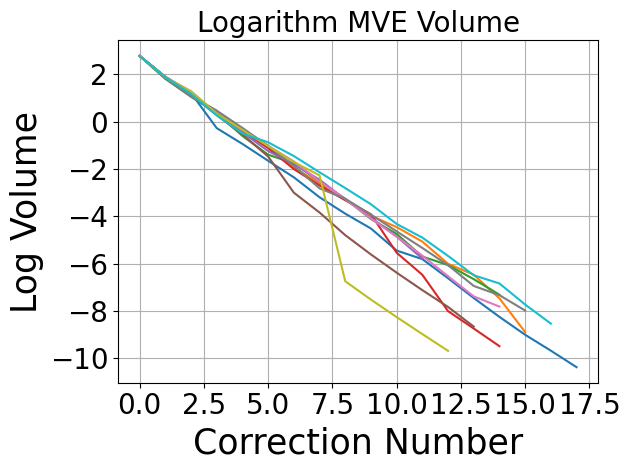

In [31]:
plt.figure()
plt.title("Logarithm MVE Volume",fontsize=20)
plt.ylabel("Log Volume",fontsize=25)
plt.xlabel("Correction Number",fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
for i in range(len(volume_logs)):
    plt.plot(np.arange(len(volume_logs[i])),volume_logs[i])
plt.tight_layout()
plt.grid()
plt.savefig('../Data/pendulum/logdet.png')
plt.show()

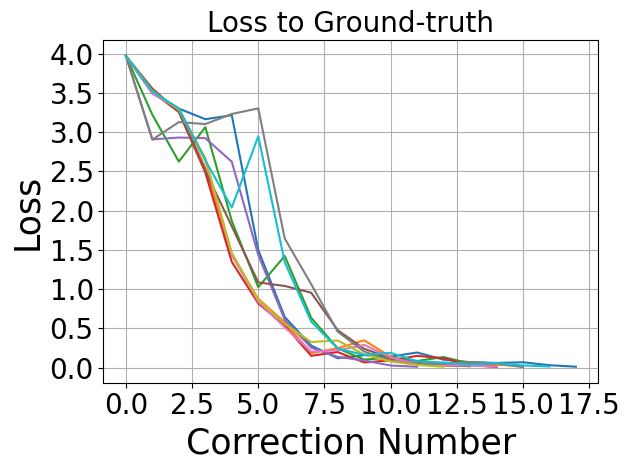

In [32]:
plt.figure()
plt.title("Parameter Error",fontsize=20)
plt.ylabel("Parameter Error Norm",fontsize=25)
plt.xlabel("Correction Number",fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
for i in range(len(error_logs)):
    plt.plot(np.arange(len(error_logs[i])),error_logs[i])
plt.tight_layout()
plt.grid()
plt.savefig('../Data/pendulum/loss.png')
plt.show()

In [33]:
def plot_theta_route(ax,theta_log):

    theta_arr=np.array(theta_log[:min(len(theta_log),20)])
    
    for i in range(min(len(theta_log) - 1,19)):
        ax.quiver(theta_arr[i,0], theta_arr[i,1], theta_arr[i+1,0] - theta_arr[i,0], theta_arr[i+1,1] - theta_arr[i,1],
                    angles='xy', scale_units='xy', scale=1,width=0.006, headwidth=3)
        
    ax.scatter(theta_arr[:,0],theta_arr[:,1],color="orange",s=30)




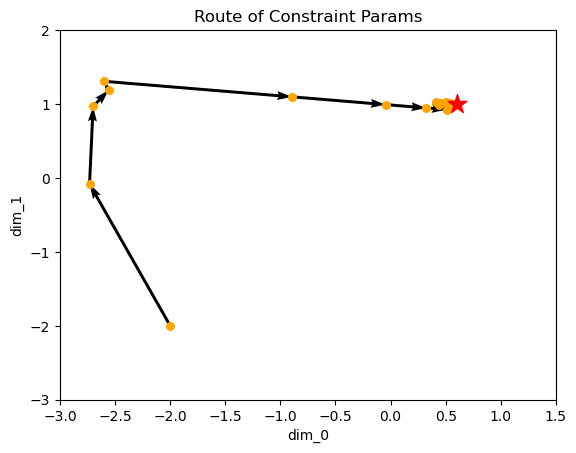

In [34]:
lbs=np.array([-2,-2]) #-6
ubs=np.array([0.5,1])

fig = plt.figure()
# plt.xlabel('dim_0')
# plt.ylabel('dim_1')
# plt.xlim(lbs[0]-1,ubs[0]+1)
# plt.ylim(lbs[1]-1,ubs[1]+1)

ax = fig.add_subplot(111)
ax.set_title("Route of Constraint Params")
ax.set_xlabel('dim_0')
ax.set_ylabel('dim_1')
ax.set_xlim(lbs[0]-1,ubs[0]+1)
ax.set_ylim(lbs[1]-1,ubs[1]+1)

#for i in range(1):
for i in range(1):   
    plot_theta_route(ax,theta_logs[i])
ax.scatter(0.6,1,marker='*',s=200,c="r")
plt.show()

In [35]:
def pendulum_eval_misspec():
    # get dynamics, set up step cost and terminal cost
    #0.05
    p_model=Pendulum_Model(10,1,1,0.4,0.02)

    P_matrix=np.array([[0.0,0],
                   [0,0.0]])
    T_matrix=np.array([[25,0],
                   [0,10]])



    dyn_func=p_model.get_dyn_f()
    step_func=p_model.get_step_cost(P_matrix,0.1)
    terminal_func=p_model.get_terminal_cost(T_matrix)

    # set up safety features
    Horizon=40
    Gamma=0.1
    def generate_phi():
            traj=cd.SX.sym('xi',3*Horizon + 2)
            phi=cd.vertcat(cd.DM(-3),traj[3:5])
            return cd.Function('phi',[traj],[phi])

    phi_func=generate_phi() #traj: [x,u,x,u,..,x] phi:[phi0, phi1, phi2]

    lbs=np.array([-1,-0.8]) #-6
    ubs=np.array([1,0.8])

    weights_init=(lbs+ubs)/2
    weights_H=np.array([0.6,1])

    #construct environment
    p_env=Pendulum_Env(10,1,1,0.4,0.02)
    p_env.set_init_state(np.array([0,0]))
    #p_env.set_noise(False)
    #construct correction agent
    agent=Correction_Agent('dummy')
    agent.set_state_dim(2)
    agent.set_ctrl_dim(1)
    agent.set_dyn(dyn_func)
    agent.set_step_cost(step_func)
    agent.set_term_cost(terminal_func)
    agent.set_g(phi_func,weights=weights_H,gamma=Gamma)
    #agent.set_threshold(-0.1) #-0.5
    agent.set_threshold(-0.25) #-0.5
    agent.set_p(0.3)
    agent.construct_graph(horizon=Horizon)

    #construct controller
    controller=ocsolver_v2('pendulum control')
    controller.set_state_param(2,[-2*np.pi,-100],[2*np.pi,100])
    controller.set_ctrl_param(1,[-1e10],[1e10])
    controller.set_dyn(dyn_func)
    controller.set_step_cost(step_func)
    controller.set_term_cost(terminal_func)
    #controller.construct_graph(horizon=Horizon)
    controller.set_g(phi_func,gamma=Gamma)
    controller.construct_prob(horizon=Horizon)

    #construct cutter
    hb_calculator=cutter_v2('pendulum cut')
    hb_calculator.from_controller(controller)
    hb_calculator.construct_graph(horizon=Horizon)

    #construct MVESolver
    mve_calc=mvesolver('pendulum_mve',2)

    mve_calc.set_init_constraint(lbs, ubs) #Theta_0

    learned_theta=np.array(weights_init)

    #learning logs
    theta_log=[np.array(weights_init)]
    error_log=[np.linalg.norm(weights_init-weights_H)]

    d_0,C_0=mve_calc.solve()
    v_0=np.log(np.linalg.det(C_0))
    volume_log=[v_0]

    EPISODE=0
    corr_num=0
    termination_flag=False
    while not termination_flag:
        #print('episode',EPISODE)
        # random init
        init_state=np.array([0,0])
        init_state[0] += np.random.uniform(0,2*np.pi/3)
        init_state[1] += np.random.uniform(0,3)
        p_env.set_init_state(init_state)
        for i in range(200):
            x=p_env.get_curr_state()
            if np.sqrt(np.sum((x-np.array([np.pi,0]))**2)) <=0.15:
                print('reached desired position')
                break
            #print(i)
            u=controller.control(x,weights=learned_theta)
            agent_output=agent.act(controller.opt_traj)
            if agent_output is None:
                #print('emergency stop')
                break
            elif type(agent_output)==bool:
                pass
            else:
                h,b,h_phi,b_phi=hb_calculator.calc_planes(learned_theta,x,controller.opt_traj,np.sign(agent_output))
                #print('cutting plane calculated')
                #print('h',h)
                #print('b',b)
                #print('diff', h.T @ learned_theta - b)
                #print('h_phi',h_phi)
                #print('b_phi',b_phi)

                mve_calc.add_constraint(h,b[0])
                mve_calc.add_constraint(h_phi,b_phi[0])
                learned_theta,C=mve_calc.solve()
                #difference=np.linalg.norm(learned_theta-weights_H)
                difference=learned_theta-weights_H
                vol=np.log(np.linalg.det(C))
                #print('leanred safety param',learned_theta)
                theta_log.append(learned_theta)
                #print('difference', difference)
                error_log.append(np.linalg.norm(difference))
                #print('volume', vol)
                volume_log.append(vol)
                #mve_calc.draw(C,learned_theta,weights_H)
                #if np.max(np.abs(difference))<0.04:

                corr_num+=1
                
                if corr_num==7:
                    print("stop correcting ",learned_theta)
                    termination_flag=True
                    break
                
                
            p_env.step(u)
        #p_env.show_animation()
        EPISODE+=1

    return theta_log, error_log, volume_log


In [36]:
misspec_theta_log,_,_=pendulum_eval_misspec()

reached desired position
stop correcting  [0.77069537 0.67255758]


[0.77069537 0.67255758]


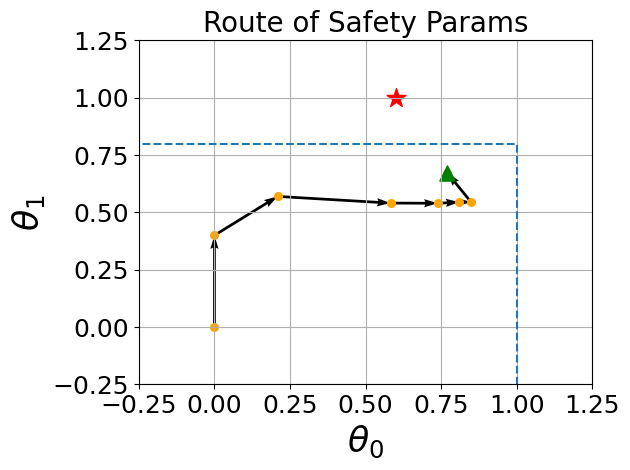

In [37]:

print(misspec_theta_log[-1])
lbs=np.array([-0.25,-0.25]) #-6
ubs=np.array([1.25,1.25])

fig = plt.figure()
# plt.xlabel('dim_0')
# plt.ylabel('dim_1')
# plt.xlim(lbs[0]-1,ubs[0]+1)
# plt.ylim(lbs[1]-1,ubs[1]+1)

ax = fig.add_subplot(111)
ax.set_title("Route of Safety Params",fontsize=20)
# ax.set_xlabel('dim$_0$',fontsize=25)
# ax.set_ylabel('dim$_1$',fontsize=25)
ax.set_xlabel(r'$\theta_0$',fontsize=25)
ax.set_ylabel(r'$\theta_1$',fontsize=25)
ax.set_xlim(lbs[0],ubs[0])
ax.set_ylim(lbs[1],ubs[1])

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
#ax.set_xticklabels([0.0,0.25,0.5,0.75,1.0])
#for i in range(1):
for i in range(1):   
    plot_theta_route(ax,misspec_theta_log)
ax.scatter(0.6,1,marker='*',s=200,c="r")
ax.scatter(misspec_theta_log[-1][0],misspec_theta_log[-1][1],marker='^',s=120,c="g")
ax.plot((-1,1,1),(0.8,0.8,-0.8),linestyle='dashed')
ax.grid()
plt.tight_layout()
plt.show()